<a href="https://colab.research.google.com/github/stephenadhi/nn-mpc/blob/main/EVALIDASI-testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.executable
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from pandas import DataFrame
from pandas import read_csv
import math
from numpy import savetxt
from keras import layers
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape, Dropout
from tensorflow.keras.models import Model, Sequential
from scipy.integrate import odeint, RK45
from tensorflow.keras.utils import plot_model
import timeit
tf.keras.backend.set_floatx('float64')

In [ ]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs



## Mass-Spring-System
<img src="https://github.com/stephenadhi/nn-mpc/blob/main/mass-spring-damper.png?raw=1">


In [ ]:
# Use ODEINT to solve the differential equations defined by the vector field
from scipy.integrate import odeint

def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x1, v1, x2, v2, x3, v3 = w
    m, k, kp, u1, u2, dist = p

    # Create f = (x1',y1',x2',y2'):
    f = [v1,
         (k * ((-2 * x1) + x2) + kp * (-x1 ** 3 + (x2 - x1) ** 3)) / m + u1,
         v2,
         (k * (x1 - (2 * x2) + x3) + kp * ((x3 - x2) ** 3 - (x2 - x1) ** 3)) / m + u2,
         v3,
         (k * (x2 - x3) + kp * ((x2 - x3) ** 3)) / m + dist]
    return f

# Use Best Training Data

In [ ]:
df = pd.read_csv('u1000newage20000_0.001ssim.csv')
train_df = df
#val_df = df[int(0.5*n):int(1*n)]
val_df= pd.read_csv('u1000validationdatanewage5k_0.001ssim.csv')
test_df = pd.read_csv('u1000validationdatanewage5k_0.001ssim.csv')

#num_features = df.shape[1]
val_df.shape

(5001, 9)

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()
train_mean

u1       -8.341807
dist.    -0.479247
u2       -1.244875
x1       -0.019089
x3       -0.035518
diff21    0.000209
diff23    0.000015
diff1     0.000105
diff3     0.000009
dtype: float64

# Data preprocessing and NN model setup

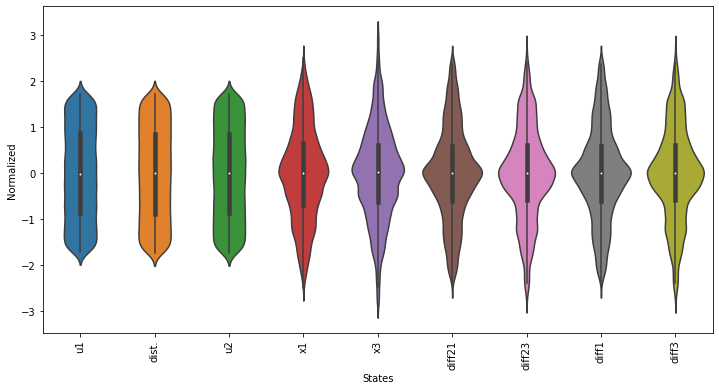

In [ ]:
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
#train_df = (train_df - train_df.min()) / (train_df.max() - train_df.min())
#val_df = (val_df - train_df.min()) / (train_df.max() - train_df.min())
#test_df = (test_df - train_df.min()) / (train_df.max() - train_df.min())
#plot
#df_std = (df - df.min()) / (df.max()-df.min())
df_std = (df - train_mean) / df.std()
#df_std.iloc[:,0:3] = df_std.iloc[:,0:3].values * 3
#df_std = (df - df.min()) / (df.max() - df.min())
df_std = df_std.astype('float64')
df_std = df_std.melt(var_name='States', value_name='Normalized')
plt.figure(figsize=(12, 6))

ax = sns.violinplot(x='States', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)
plt.savefig('Normalized.png', dpi=300)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, 
               #test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, plot_col, model=None, max_subplots=1):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Timestep ')

WindowGenerator.plot = plot

In [ ]:
batchsize= 32

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float64)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=batchsize,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

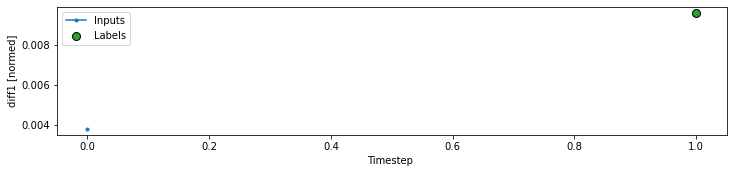

In [ ]:
OUT_STEPS = 1
multi_window = WindowGenerator(input_width=1,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                              label_columns= ['diff1','diff3']
                              )

multi_window.plot('diff1')

In [ ]:
multi_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['diff1', 'diff3']

In [ ]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 2)


In [ ]:
MAX_EPOCHS = 100
def compile(model, lr=0.001):
      model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=lr),
                metrics=[tf.metrics.MeanSquaredError()],
                   experimental_steps_per_execution=10

                    )
        
def scheduler(epoch, lr):
    if epoch > 100:
        return lr * tf.math.exp(-0.01)
    else: return lr

def fit(model, window, patience=150):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,
                   #  callback
                                ]
                     )
  return history

multi_val_performance = {}
multi_performance = {}
num_label=2

In [ ]:
#set number of hidden nodes
n_hidden_nodes= 40

In [ ]:
from functools import partial
multi_resdense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
  tf.keras.layers.Dense(n_hidden_nodes, activation=partial(tf.nn.leaky_relu, alpha=0.5)),
    tf.keras.layers.Dense(OUT_STEPS*num_label,
                         kernel_initializer=tf.initializers.zeros
                         ),
])
compile(multi_resdense_model,lr=0.001)

## Use best model - 40 hidden nodes

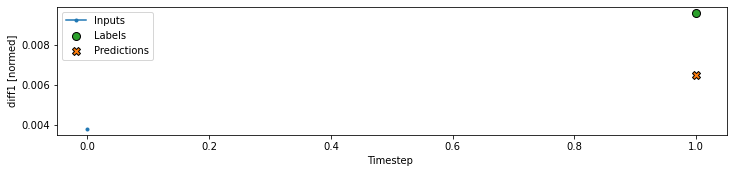

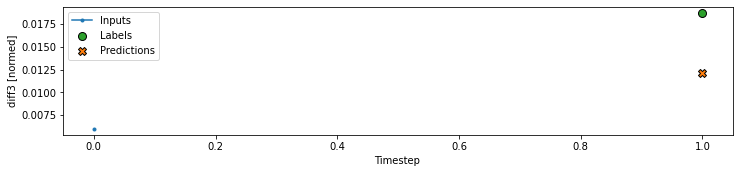

In [ ]:
#Import best nodel
multi_resdense_model.load_weights('./checkpoints/0.001s20knewageresdense1-1batch32allep100lrelu40diff2u1000')
multi_window.plot('diff1',model=multi_resdense_model)
multi_window.plot('diff3',model=multi_resdense_model)

# Function to Standardize

In [ ]:
xmean=train_mean[{'x1','x3'}]
xmean=xmean[['x1','x3']]
diffmean=train_mean[{'diff1','diff3'}]
diffmean=diffmean[['diff1','diff3']]
diffmean

diff1    0.000105
diff3    0.000009
dtype: float64

In [ ]:
xstd=train_std[{'x1','x3'}]
xstd=xstd[['x1','x3']]
diffstd=train_std[{'diff1','diff3'}]
diffstd=diffstd[['diff1','diff3']]
diffstd

diff1    0.054699
diff3    0.052277
dtype: float64

In [ ]:
def standardize(modelinput):
    modelinput = (modelinput -train_mean.values) / train_std.values
    return modelinput

def destandardize(modeloutput):
    modeloutput = (modeloutput * train_std.values) + train_mean.values
    return modeloutput

def denormalize(outputs):
    outputs = outputs * diffstd + diffmean
    return outputs

# Initial Setup

In [ ]:
num_rollouts= 1
# Masses:
m = 0.5 
# Spring constants
kp = 63.5
k = 217.0
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6
scale=1
num_data= 4
interval= 0.001
stoptime = interval*(num_data)
np.random.seed(28)
hist= np.zeros((1,15))
hist[0,0:3]=[0,0,0]
dist = 200*(np.random.rand(num_data+1)-0.5)
#dist= np.zeros((num_data+1,1))
for roll in range(num_rollouts):
    frames=0
    #act1= 0*(np.random.rand(num_data+1)-0.5)
    #act2= 0*(np.random.rand(num_data+1)-0.5)
    act1 = np.zeros((num_data+1,1))
    act2 = np.zeros((num_data+1,1))
    #Initial states
    w0 = np.zeros((1,6))
    #w0= np.random.randn(1,6)
    w0= w0.flatten()
    prev = [[w0[0],w0[4]]]
    value1= w0[0]
    value3= w0[4]
    # Pack up the parameters and initial conditions:
    p = [m, k, kp, act1[0], dist[0], act2[0]]
    # Call the ODE solver.
    t1= np.array([0,interval])
    wsol1 = odeint(vectorfield, w0, t1, args=(p,),
            atol=abserr, rtol=relerr)
    wsol1 = wsol1.flatten()
    wcurr = np.array([wsol1[6:]])
    w0=wsol1[6:]
    diff1= w0[0] - value1
    diff3= w0[4] - value3
    diff= [[diff1, diff3]]
    diff2=diff
    #curr = np.hstack((np.array([[act1[1]]]),np.array([[dist[1]]]),np.array([[act2[1]]]),prev,diff2,diff,wcurr))
    curr = np.hstack((np.array([act1[1]]),np.array([[dist[1]]]),np.array([act2[1]]),prev,diff2,diff, wcurr))
    hist= np.vstack((hist, curr))
    #print(w0)
    prevv= prev
    prev = [[w0[0],w0[4]]]
    value11=value1
    value33=value3
    value1= w0[0]
    value3= w0[4]
    # Pack up the parameters and initial conditions:
    p = [m, k, kp, act1[1], dist[1],act2[1]]
    # Call the ODE solver.
    t2= np.array([0+interval,interval+interval])
    wsol1 = odeint(vectorfield, w0, t2, args=(p,),
            atol=abserr, rtol=relerr)
    wsol1 = wsol1.flatten()
    wcurr = np.array([wsol1[6:]])
    w0=wsol1[6:]
    diff1= w0[0] - value1
    diff3= w0[4] - value3
    diff21= w0[0] - value11
    diff23= w0[4] - value33
    diff= [[diff1, diff3]]
    diff2= [[diff21, diff23]]
    #print(w0)
 #   curr = np.hstack((np.array([[act1[2]]]),np.array([[dist[2]]]),np.array([[act2[2]]]),prev,diff2,diff, wcurr))
    curr = np.hstack((np.array([act1[2]]),np.array([[dist[2]]]),np.array([act2[2]]),prev,diff2,diff, wcurr))
    hist= np.vstack((hist, curr))
    lag=2
    for ts in range(num_data-lag):
        prevv = prev
        t = np.array([stoptime * float(ts+lag) / (num_data), stoptime * float(ts + lag + 1) / (num_data)])
        p = [m, k, kp, act1[ts+lag],dist[ts+lag], act2[ts+lag]]
        # Call the ODE solver.
        wsol1 = odeint(vectorfield, w0, t, args=(p,),atol=abserr, rtol=relerr)
        wsol1 = wsol1.flatten()
        prev = np.array([[wsol1[0],wsol1[4]]])
        value11=value1
        value33=value3
        value1= wsol1[0]
        value3= wsol1[4]
        w0 = wsol1[6:]
        #print(ts)
        #print(w0)
        diff1= w0[0] - value1
        diff3= w0[4] - value3
        diff21= w0[0] - value11
        diff23= w0[4] - value33
        diff= [[diff1, diff3]]
        diff2= [[diff21, diff23]]
        action= [act1[ts+lag+1],dist[ts+lag+1]]
        #new = np.hstack((np.array([action]),np.array([[act2[ts+lag+1]]]),prev,diff2,diff, np.array([w0])))
        new = np.hstack((np.array([act1[ts+lag+1]]),np.array([[dist[ts+lag+1]]]),np.array([act2[ts+lag+1]]),prev,diff2,diff, np.array([w0])))  
        # print("new: ",new)
        hist = np.vstack((hist, new))
            
history=pd.DataFrame(data=hist,columns =["u1","dist.","u2","prev1","prev3","diff21","diff23","diff1","diff3","x1", "v1", "x2", "v2", "x3", "v3"])    

historyy=pd.DataFrame(history[:])
history=historyy[-3:][{"u1","u2","diff21","diff23","dist.","diff1","diff3","x1","x3"}]
history=history[["u1","dist.","u2","x1","x3","diff21","diff23","diff1","diff3"]]
history=history.values
historyy

,u1,dist.,u2,prev1,prev3,diff21,diff23,diff1,diff3,x1,v1,x2,v2,x3,v3
0,0.0,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,0.0,12.247920,0.0,0.000000e+00,0.000000e+00,8.358528e-10,8.358656e-10,8.358528e-10,8.358656e-10,8.358528e-10,0.000003,0.000023,0.045796,8.358656e-10,0.000003
2,0.0,-75.006582,0.0,8.358528e-10,8.358656e-10,1.270233e-08,1.270311e-08,1.186647e-08,1.186724e-08,1.270233e-08,0.000024,0.000075,0.058002,1.270311e-08,0.000024
3,0.0,-20.481526,0.0,1.270233e-08,1.270311e-08,5.500321e-08,5.501143e-08,4.313674e-08,4.314419e-08,5.583907e-08,0.000064,0.000095,-0.017083,5.584729e-08,0.000064
4,0.0,56.261641,0.0,5.583907e-08,5.584729e-08,1.258145e-07,1.258551e-07,8.267776e-08,8.271095e-08,1.385168e-07,0.000100,0.000068,-0.037637,1.385582e-07,0.000100


# **Simulating Control Strategy**

In [ ]:
currentcost=10
horizon= 10
chor= int(horizon / 2)
ts=0
ref = np.ones((horizon,2))
ref[:,1]*=2

num_sim= 1
num_randactions=50
maxdeltau= 1000
maxact= 1000
minact= -maxact
scale=1
histo= np.zeros((3,9))
bestpred= np.zeros((horizon,2))
temp= history
#print("newtemp : ",temp)
savecost=np.zeros((num_sim,1))
start_time = timeit.default_timer()
for run in range(num_sim):
    ts+=1
    minJ=10000
    bestaction= np.zeros((horizon,2))
    #if currentcost > 0.5 and currentcost < 1:
     #   scale=0.8
    #elif currentcost > 0.2 and currentcost < 0.5:
     #   scale=0.6
    #elif currentcost > 0.1 and currentcost <0.2:
     #   scale=0.4

    #print("scale: ", scale)
    for jj in range (num_randactions):
        histo[:]= temp[:]
        prevaction= [histo[-1,0], histo[-1,2]]
        action= np.ones((horizon,2)) * prevaction
        for plan in range(chor):
            actii= maxdeltau*2*(np.random.rand(1,2)-0.5)
            action[plan:] += actii
            
            if action[plan,0] > maxact:
                action[plan:,0] = maxact
            if action[plan,0] < minact:
                action[plan:,0] = minact
            if action[plan,1] > maxact:
                action[plan:,1] = maxact
            if action[plan,1] < minact:
                action[plan:,1] = minact

       # print("action: \n", action)
        #print("histtemp: ", histo)
        prednorm = np.zeros((horizon,2))
        predstate = np.zeros((horizon,2))  
        #deltaaction= currentcost / 10000000 * np.sum((action[0]-prevaction)**2 + (action[2]-action[1])**2 + (action[1]-action[0])**2)     
        dist= 100*(np.random.rand(1)-0.5)
        for kk in range(horizon):
            histo[-1,0] = action[kk,0]
            histo[-1,1] = disturb
            histo[-1,2] = action[kk,1]
            curr = histo[-1,3:5] 
            historstd=standardize(histo)
            prednorm[kk,:]=denormalize(multi_resdense_model(np.array([historstd]))[0])
            predstate[kk,:]= curr + prednorm[kk,:]
            #print("currstate: ",histo[-1,3:5])
            #print("currpreddiff: ", prednorm)
            #print("predstate: ", predstate)
            #histo[0:-1] = histo[1:]
            #histo[-1,1]= disturb
            histo[-1,3:5]= predstate[kk,:] 
            histo[-1,5:7]= histo[-1,-2:] + prednorm[kk,:]
            histo[-1,-2:]= prednorm[kk,:]
        predJ= np.sum((predstate - ref) ** 2) 
        if currentcost < 100:
            #predJ += deltaaction
            predJ+= 10*((predstate[horizon-1,0] - predstate[0,0])**2)*currentcost 
            predJ+= 10*((predstate[horizon-1,1] - predstate[0,1])**2)*currentcost 
        #penalize small change when large error
        #if currentcost > 1:
         #   predJ -= 1000 * ((prednorm[5,1] - prednorm[0,1])**2)  
        #penalize big change when small error
        #if currentcost < 0.5:
         #   predJ += 1000 * ((prednorm[5,1] - prednorm[0,1])**2)  
        #(prednorm[0,1] -ref[0,1])**2 + (prednorm[1,1] -ref[1,1])**2
        #+ (prednorm[2,1] -ref[2,1])**2 + (prednorm[3,1] -ref[3,1])**2
        #+ (prednorm[4,1] -ref[4,1])**2 + (prednorm[5,1] -ref[5,1])**2
        #+ (prednorm[0,0] -ref[0,0])**2 + (prednorm[1,0] -ref[1,0])**2
        #+ (prednorm[2,0] -ref[2,0])**2 +  (prednorm[3,0] -ref[3,0])**2
        #+ (prednorm[4,0] -ref[4,0])**2 + (prednorm[5,0] -ref[5,0])**2

        #print(prednorm)
        if predJ < minJ:
            bestaction = action
            minJ = predJ
            bestpred= predstate

elapsed = timeit.default_timer() - start_time 
print(elapsed)
thisishistory=pd.DataFrame(data=hist,columns =["u1","dist.","u2","prev1","prev3","diff21","diff23","diff1","diff3","x1", "v1", "x2", "v2", "x3", "v3"])    

0.7856155300000864


In [ ]:
thisishistory

,u1,dist.,u2,prev1,prev3,diff21,diff23,diff1,diff3,x1,v1,x2,v2,x3,v3
0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,0.000000,12.247920,0.000000,0.000000e+00,0.000000e+00,8.358528e-10,8.358656e-10,8.358528e-10,8.358656e-10,8.358528e-10,0.000003,0.000023,0.045796,8.358656e-10,0.000003
2,0.000000,-75.006582,0.000000,8.358528e-10,8.358656e-10,1.270233e-08,1.270311e-08,1.186647e-08,1.186724e-08,1.270233e-08,0.000024,0.000075,0.058002,1.270311e-08,0.000024
3,0.000000,-20.481526,0.000000,1.270233e-08,1.270311e-08,5.500321e-08,5.501143e-08,4.313674e-08,4.314419e-08,5.583907e-08,0.000064,0.000095,-0.017083,5.584729e-08,0.000064
4,993.981776,56.261641,696.644243,5.583907e-08,5.584729e-08,1.258145e-07,1.258551e-07,8.267776e-08,8.271095e-08,1.385168e-07,0.000100,0.000068,-0.037637,1.385582e-07,0.000100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,-947.266604,-0.781590,-225.530291,1.181737e+00,1.863772e+00,-4.118977e-03,2.593243e-02,-2.763666e-03,1.293645e-02,1.178973e+00,-3.505003,1.701761,35.747365,1.876708e+00,12.809578
1201,-1000.000000,-3.555034,-188.308858,1.178973e+00,1.876708e+00,-6.975501e-03,2.559665e-02,-4.211835e-03,1.266020e-02,1.174761e+00,-4.914340,1.737417,35.559495,1.889368e+00,12.512550
1202,-1000.000000,-20.782777,-129.964514,1.174761e+00,1.889368e+00,-9.845997e-03,2.504709e-02,-5.634162e-03,1.238689e-02,1.169127e+00,-6.349229,1.772860,35.321738,1.901755e+00,12.262942
1203,-1000.000000,-40.511512,8.547941,1.169127e+00,1.901755e+00,-1.268846e-02,2.455844e-02,-7.054294e-03,1.217154e-02,1.162073e+00,-7.754181,1.808039,35.030228,1.913927e+00,12.081827


# Save to .CSV

In [ ]:
#thisishistory.to_csv('dist50sim300-1000-1000-pen10xcost.csv',index=False)

In [ ]:
thisishistory= pd.read_csv('1611changemassnodistchangerefreinf_startsim40000_train500-250_batch16sim300-1000-1000-pen5.csv')

In [ ]:
thisishistory[40000:]

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
40000,-29.715122,-1.230610,212.007632,1.207075,4.246181,-0.064952,-0.220420,-0.033720,-0.114740
40001,0.000000,-0.351397,0.000000,1.172187,4.122752,-0.068608,-0.238169,-0.034889,-0.123429
40002,203.251646,1.027696,583.881472,1.136948,3.992740,-0.070127,-0.253441,-0.035239,-0.130012
40003,1000.000000,0.149193,1000.000000,1.103733,3.859438,-0.068454,-0.263314,-0.033215,-0.133302
40004,1000.000000,1.692636,1000.000000,1.074514,3.724851,-0.062434,-0.267889,-0.029219,-0.134587
...,...,...,...,...,...,...,...,...,...
40596,545.208811,-0.779952,-304.612972,-0.008962,0.007558,-0.016553,-0.003056,-0.007786,-0.001503
40597,1000.000000,2.055010,74.273484,-0.013300,0.005897,-0.012123,-0.003164,-0.004338,-0.001661
40598,1000.000000,-0.702575,509.324539,-0.013186,0.005794,-0.004223,-0.001764,0.000114,-0.000103
40599,1000.000000,0.258111,30.515123,-0.008545,0.007243,0.004755,0.001346,0.004640,0.001449


# Evaluate using Designed Metrics

In [ ]:
actionshist= np.hstack([np.array([thisishistory.iloc[3:-1,0].values]).transpose(),np.array([thisishistory.iloc[3:-1,2].values]).transpose()])
actionshistory=pd.DataFrame(data=actionshist, columns=["u1","u2"])
actionshistory.insert(1,"prevu1", actionshistory.iloc[:,0].shift(1))
actionshistory.insert(3,"prevu2", actionshistory.iloc[:,2].shift(1))
diffu1= actionshistory["u1"] - actionshistory["prevu1"]
diffu2= actionshistory["u2"] - actionshistory["prevu2"]
actionshistory.insert(4,"diffu2", diffu2)
actionshistory.insert(2,"diffu1", diffu1)
deltaudt= actionshistory[["diffu1","diffu2"]]
deltaudt=deltaudt.dropna()
np.sqrt(deltaudt[40000:] ** 2).mean()

diffu1    300.387706
diffu2    319.123950
dtype: float64

In [ ]:
meanu=np.sqrt(np.square(thisishistory.iloc[40000:,:3])).mean()
meanu

u1       694.152258
dist.      0.742920
u2       670.215523
dtype: float64

In [ ]:
thisishistory.min()

u1       -1000.000000
dist.       -4.258709
u2       -1000.000000
x1          -3.882404
x3          -8.402543
diff21      -0.532621
diff23      -0.655551
diff1       -0.266949
diff3       -0.328215
dtype: float64

In [ ]:
meandiff= np.sqrt(np.square(thisishistory.iloc[40000:,-2:])).mean()
meandiff

diff1    0.011318
diff3    0.013919
dtype: float64

In [ ]:
#action_sequence= thisishistory.iloc[:,0:3].values
#action_sequence=pd.DataFrame(action_sequence)
#action_sequence.to_csv('action_sequence.csv', index=False)

In [ ]:
plot_out=['x1','x3']

In [ ]:
thisishistory.iloc[40001]

u1        0.000000
dist.    -0.351397
u2        0.000000
x1        1.172187
x3        4.122752
diff21   -0.068608
diff23   -0.238169
diff1    -0.034889
diff3    -0.123429
Name: 40001, dtype: float64

In [ ]:
RMSE= (np.sqrt(np.square(thisishistory[plot_out][40100:40300].values - [1,2]).mean()) + np.sqrt(np.square(thisishistory[plot_out][40400:40600].values - [0,0]).mean()))/2
RMSE

0.04301715812183654

# Plotting

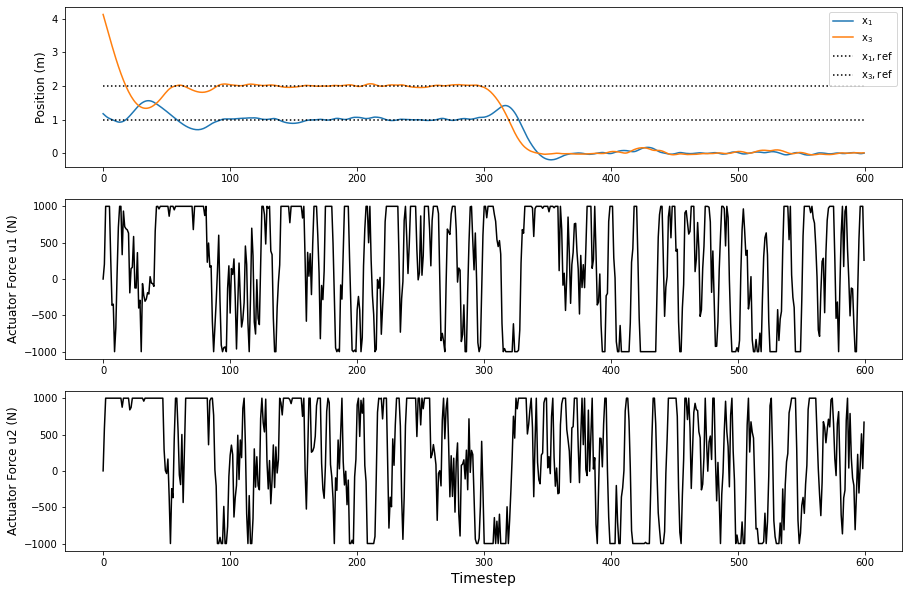

In [ ]:
fig, axs = plt.subplots(3, sharex=False,figsize=(15,10))
x= range(600)
y1=thisishistory.iloc[-600:,3].values
y2=thisishistory.iloc[-600:,4].values
ref=np.ones((600,2))
ref[:,1]*=2
#both=np.hstack((y,ref))
z=thisishistory.iloc[-600:,4].values
uone= thisishistory.iloc[-600:,0].values
utwo= thisishistory.iloc[-600:,2].values
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
#axs[0].set_title('System Outputs over Time', fontsize=20)
axs[0].plot(x, y1, label='$x_1$')
axs[0].plot(x, y2, label='$x_3$')
axs[0].plot(x, ref[:,0], 'k:',label= '$x_1,ref$')
axs[0].plot(x, ref[:,1], 'k:',label= '$x_3,ref$')
axs[1].plot(x, uone, 'k')
axs[2].plot(x, utwo,'k')
axs[0].set_ylabel("Position (m)", fontsize=12)
axs[1].set_ylabel("Actuator Force u1 (N)",fontsize=12) 
axs[2].set_ylabel("Actuator Force u2 (N)", fontsize=12)
axs[2].set_xlabel("Timestep", fontsize=14) 
#fig.legend(loc='upper right',bbox_to_anchor=(0.4, 0.26, 0.5, 0.62),fontsize=10)
fig.legend(loc='upper right',bbox_to_anchor=(0.4, 0.26, 0.50, 0.62),fontsize=10)
#plt.savefig('dist50sim300-1000-1000-pen10xcost.png', dpi=300)

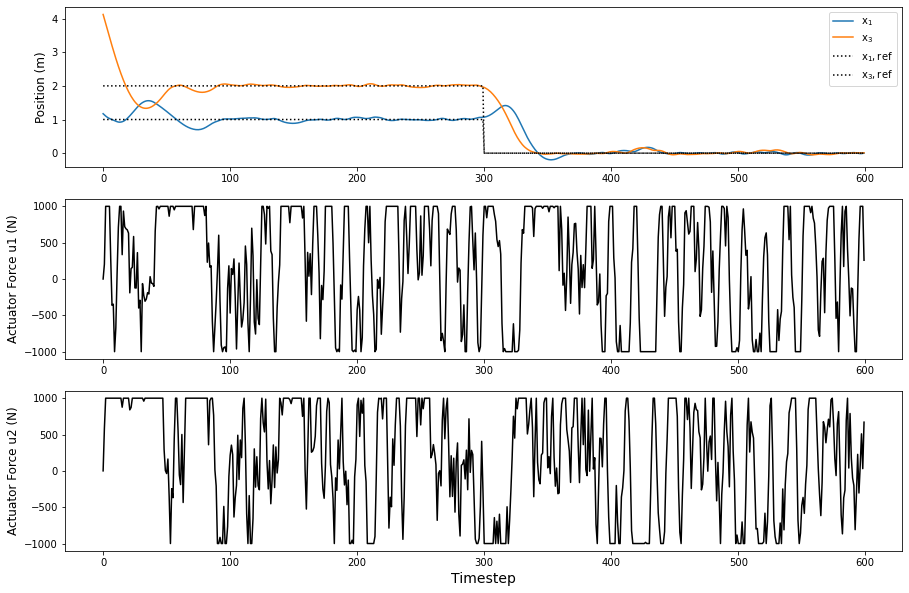

In [ ]:
fig, axs = plt.subplots(3, sharex=False,figsize=(15,10))
x= range(600)
y1=thisishistory.iloc[-600:,3].values
y2=thisishistory.iloc[-600:,4].values
ref=np.ones((600,2))
ref[:,1]*=2
ref[300:,:]=0
#both=np.hstack((y,ref))
z=thisishistory.iloc[-600:,4].values
uone= thisishistory.iloc[-600:,0].values
utwo= thisishistory.iloc[-600:,2].values
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
#axs[0].set_title('System Outputs over Time', fontsize=20)
axs[0].plot(x, y1, label='$x_1$')
axs[0].plot(x, y2, label='$x_3$')
axs[0].plot(x, ref[:,0], 'k:',label= '$x_1,ref$')
axs[0].plot(x, ref[:,1], 'k:',label= '$x_3,ref$')
axs[1].plot(x, uone, 'k')
axs[2].plot(x, utwo,'k')
axs[0].set_ylabel("Position (m)", fontsize=12)
axs[1].set_ylabel("Actuator Force u1 (N)",fontsize=12) 
axs[2].set_ylabel("Actuator Force u2 (N)", fontsize=12)
axs[2].set_xlabel("Timestep", fontsize=14) 
#fig.legend(loc='upper right',bbox_to_anchor=(0.4, 0.26, 0.5, 0.62),fontsize=10)
fig.legend(loc='upper right',bbox_to_anchor=(0.4, 0.26, 0.5, 0.62),fontsize=10)
plt.savefig('changemassreinf.png', dpi=300)

In [ ]:
axs[1].plot(x, uone, 'k')
axs[2].plot(x, utwo,'k')
axs[0].set_ylabel("Position (m)")
axs[0].set_xlabel("Timestep") 
axs[1].set_ylabel("u1 (N)") 
axs[2].set_ylabel("u2 (N)")
axs[2].set_xlabel("Timestep") 

Text(0.5, 21.200000000000003, 'Timestep')

Text(0.5, 0, 'Time (ms)')

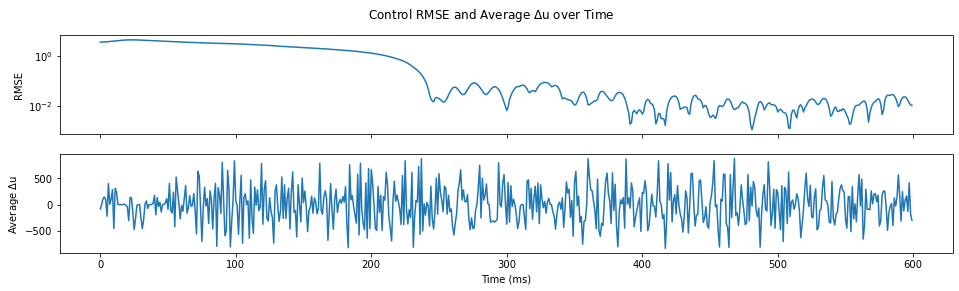

In [ ]:
from matplotlib import rc
fig, axs = plt.subplots(2, sharex=True,figsize=(16,4))
x= range(600)
r1= np.sqrt(np.square(thisishistory[plot_out][-600:].values - [1,2]))[:,0]
r2= np.sqrt(np.square(thisishistory[plot_out][-600:].values - [1,2]))[:,1]
r= (r1+r2)/2
du1=deltaudt.iloc[-600:,0].values
du2=deltaudt.iloc[-600:,1].values
du=(du1+du2)/2

fig.suptitle(r'Control RMSE and Average $\Delta$u over Time')
axs[0].semilogy(x,r)
axs[1].plot(x,du)

axs[0].set_ylabel('RMSE') 
axs[1].set_ylabel(r'Average $\Delta$u') 



axs[1].set_xlabel("Time (ms)") 
#axs[0].set_title("Position (m)") 
#axs[0].plot(range(5000), aaa.iloc[:,3].values, 'B')
#plt.savefig('reinf_startsim10000_train500-250_batch16sim300-1000-1000-pen10xcost.png', dpi=300)